# FrozenLake Policy Iteration

This is the openai gym environment, FrozenLake in its 4x4 and 8x8, probabilistic and deterministic variants. Dynamic programming is used and the model gets a 100% solve rate in deterministic environments and roughly a 10% solve rate in probabilistic or "slippery" environments. 

**Dynamic programming** is a brute force method of solving Markov Decision Processes or MDPs. MDPs have the *Strong Markovian Property*; a future state is determined only by the current state and action and not previous states and actions.

**An MDP is a tuple consisting of:**

__S__ - All states

**A** - All actions that can be taken by an agent

__r(s, a, s')__ - *Reward model* giving expected reward for taking action **a** in state __s__ 
and ending up in state **s'**

**T(s'|s, a)** - *Transition probability matrix*; probability that taking action **a** in state __s__ leads to                       state **s'**

__γ__ - *Discount factor*; Value between [0, 1] that represents relative importance between present and future               rewards

        If γ = 1 future rewards are not weighted differently to present rewards
        
        If γ = 0 future rewards are not taken into consideration at all
        
        γ = 0.9 is usually a good starting point (Since this is a hyperparameter you will have to tune it)

A policy **π(s) = a** is the action **a** an agent takes when in state __s__. Policies can be either stochastic (e.g epsilon-greedy policy) or deterministic (greedy policy); but here we will only use a deterministic/greedy policy.

The value of a state, or state-value, is the cumulative reward an agent expects to receive when in a state and following a certain policy. If __γ__ < 1 then this is the **discounted** cumulative reward.

The Bellman equation is used to relate the value of the current state to the reward it gets, plus the value of the next state (for a given policy).

The first question one might ask when thinking about this is "how do we know what the value of the next state is?" and this is where dynamic programming - an iterative algorithm- comes in. We start off with all values initialised to zero. Then as we go through states using the Bellman equation and recieve rewards, we start getting approximates for what the value function is. As we go through more iterations, the value function "bootstraps" itself and converges to its true value for the given policy.

**V_π(s) = r(s,a,s') + γV_π(s')** <-- the Bellman equation, a state-value function for policy π

For stochastic environments (like the slippery FrozenLake) we need to add the values for each possible next state
weighted by that state's probaility of occuring -> **T(s'|s, a)**


Once we have found the values for all states we will update the policy to choose actions that lead to states with the highest value - acting greedily. We do this by finding the action which has the highest action value
    action value = 

The policy iteration algorithm goes as follows:
1. start with a random policy and value function and set epsilon - threshold for convergence
2. policy evaluation:
    delta = 0
    for every state:
        old = V_π(s) 
        s' = take action π(s) in the environment
        new = r(s,a,s') + γV_π(s')
        V_π(s) = new
        delta = max(delta, abs(new - old))
        if delta < epsilon then GOTO 3
3. policy improvement: 
    for every state
        π(s) = choose action which leads to state with the highest value function #"acting greedily"
    if policy has converged then STOP else GOTO 2

NOTE: Here we are giving a very basic overview of the algorithm without going too in detail into the equations and derivation. If you want a deeper and formal understanding then it is strongly recommended to do extra reading. Resources given below.
  

In [1]:
#import dependencies
import gym
from gym.envs.registration import register
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter

In [2]:
#registering environments that are deterministic based on the 4x4 and 8x8 grids
#this code was copied from https://github.com/openai/gym/issues/565
register(
    id='DeterministicFrozenLake-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

register(
    id='DeterministicFrozenLake8x8-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '8x8', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

In [3]:
#this is used after training to see how our policy performs
def execute(env, policy, render=False, num_tests=100):
    """env: openai gym environment
       policy: dictionary, policy[state] is action for state that this policy takes """
    
    episode_steps = []
    num_completed = 0
    for _ in range(num_tests):
        steps = 0
        state = env.reset() #starting state
        while True:
            if render:
                env.render()
                time.sleep(0.5) #gives a pause between each move for easy viewing
            
            #environment returns the state, reward, is the game finished, debugging info
            #this is based on the action taken by the agent
            #the action is determined by the policy for that state
            action = policy[state]
            state, reward, done, _ = env.step(action) 
            
            steps += 1
            if done: break
        
        #check if we reached the terminal(goal) state
        if state == env.env.nS-1: #if reward == 1:       is an equivalent condition in this case 
            num_completed += 1
            episode_steps.append(steps) # list of number of steps it took to finish game
        
    return episode_steps, num_completed

In [4]:
#the algorithm doing all the work

def policy_evaluation(env, policy, V, GAMMA=0.9):
    epsilon = 1e-3 #the number the delta should be smaller than
    while True:
        delta = 0
        for s in range(env.env.nS-1):
            old = V[s]
            V[s] = 0
            action = policy[s]
            #going through all s' that (s, a) could lead to. For determninistic envirnoments there is only one s'
            for (prob, next_state, reward, _) in env.env.P[s][action]: 
                V[s] += prob * (reward + GAMMA * V[next_state]) #bellman equation used to update value function
            
            #the most the value function was off compared to its previous value
            #this will be a small number when converged
            delta = max(delta, abs(V[s]-old)) 
        if delta < epsilon: break
    return V

def policy_improvement(env, policy, V, GAMMA=0.9):
    stable = True
    for s in range(env.env.nS-1):
        old = policy[s]
        best_value = float('-inf')
        #choosing best action (action which leads to the state with the highest value)
        for action in range(env.env.nA-1):
            action_value = 0
            #going through all s' that (s, a) could lead to. For determninistic envirnoments there is only one s'
            for (prob, next_state, reward, _) in env.env.P[s][action]:
                action_value += prob * (reward + GAMMA * V[next_state]) 
            if action_value > best_value:
                best_value, best_action = action_value, action

        if best_action != old:
            stable = False
            
        policy[s] = best_action
        
    return policy, stable

Completed the game 12 / 100 times


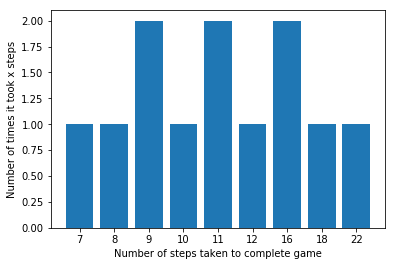

In [5]:
if __name__ == "__main__":
    env = gym.make("FrozenLake-v0")
    #env = gym.make("DeterministicFrozenLake-v0")
    #env = gym.make("FrozenLake8x8-v0")
    #env = gym.make("DeterministicFrozenLake8x8-v0")
    # the actions are ACTIONS = (0,1,2,3) LEFT, UP, RIGHT, DOWN
    
    RENDER = False #set to True if you want to see the game being played (reduce NUM_TESTS to ~3-5)
    NUM_TESTS = 100 #number of game tests
    NUM_EPOCHS = 1000 #number of training iterations
    
    #initialising value function V(s)
    #NOTE: value "function" is actually a LIST of state-values
    V = [0 for _ in range(env.env.nS)]
    #V[env.env.nS-1] = 1
    #policy initiated with random actions for each state 
    policy = {state: np.random.randint(0, env.env.nA) for state in range(env.env.nS)} 
    
    #policy iteration algorithm: policy1-> valuefunction1-> policy2-> valuefunction2-> ...
    for i in range(NUM_EPOCHS):
        
        #_stable gives a definitive point to when the policy has converged EXCEPT in the 
        #case of two or more equally optimal actions. see if you can find a way around this
        V = policy_evaluation(env, policy, V)
        policy, _stable = policy_improvement(env, policy, V)
        
    #testing the policy
    episode_steps, num_completed = execute(env, policy, render=RENDER, num_tests=NUM_TESTS)
    
    print("Completed the game", num_completed, "/", NUM_TESTS, "times")
    
    #number of times it took n steps to complete
    episode_steps = Counter(episode_steps) 
    
    #plotting graph
    heights = [episode_steps[n] for n in sorted(episode_steps.keys())]
    plt.bar(range(len(episode_steps)), heights, align='center', width=0.8)
    plt.xticks(range(len(episode_steps)), sorted(episode_steps.keys()))
    plt.xlabel("Number of steps taken to complete game")
    plt.ylabel("Number of times it took x steps")
    plt.show()

Acknowledgements:
Siraj Raval, Colin Skow and the rest of the School of AI team have provided excellent learning material in the form of their free course *Introduction to Reinforcment Learning*

*Reinforcement Learning: An Introduction by Sutton and Barto* has been a tremendous resource

These are some useful articles:
https://towardsdatascience.com/reinforcement-learning-demystified-36c39c11ec14
https://towardsdatascience.com/reinforcement-learning-demystified-solving-mdps-with-dynamic-programming-b52c8093c919
https://stackoverflow.com/questions/37370015/what-is-the-difference-between-value-iteration-and-policy-iteration